In [10]:
"""
Created on Thu Nov  1 12:57:54 2018

@author: mikyl
"""

'\nCreated on Thu Nov  1 12:57:54 2018\n\n@author: mikyl\n'

# CRQ1

Does the fare for mile change across NY's borough? We want to discover whether the expenses of a user that enjoys Taxis in one zone is different from those that uses it in another one.

Considering the fare amount:
- Compute the price per mile equation for each trip.
- Run the mean and the standard deviation of the new variable for each borough. Then plot the distribution. What do you see?
- Run the t-test among all the possible pairs of distribution of different boroughs.
- Can you say that statistically significant differences, on the averages, hold among zones? In other words, are Taxis trip in some boroughs, on average, more expensive than others?

The price per mile might depend on traffic the Taxi finds on its way. So we try to mitigate this effect:
- Likely, the duration of the trip says something about the city's congestion, especially if combined with the distances. It might be a good idea to weight the price for mile using the time equation needed to complete the trip. Thus, instead of equation, you can use equation, where equation is the time needed to complete the trip.
- Run the mean and the standard deviation of the new variable for each borough. Then plot the distribution. What do you see?
- Run the t-test among all the possible pairs of new distribution of different boroughs.
- Can you say that statistically significant differences, on the averages, hold among zones? In other words, are Taxis trip in some boroughs, on average, more expensive than others?
- Compare the results obtained for the price per mile and the weighted price for mile. What do you think about that?


Let's import all the needed libraries

In [11]:
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns",10)

Here we locate all the csvs

In [12]:
Location_Jan = r"C:\Users\mikyl\Documents\GitHub\ADM-HW2-Group-3\data\yellow_tripdata_2018-01.csv"
Location_Feb = r"C:\Users\mikyl\Documents\GitHub\ADM-HW2-Group-3\data\yellow_tripdata_2018-02.csv"
Location_Mar = r"C:\Users\mikyl\Documents\GitHub\ADM-HW2-Group-3\data\yellow_tripdata_2018-03.csv"
Location_Apr = r"C:\Users\mikyl\Documents\GitHub\ADM-HW2-Group-3\data\yellow_tripdata_2018-04.csv"
Location_May = r"C:\Users\mikyl\Documents\GitHub\ADM-HW2-Group-3\data\yellow_tripdata_2018-05.csv"
Location_Jun = r"C:\Users\mikyl\Documents\GitHub\ADM-HW2-Group-3\data\yellow_tripdata_2018-06.csv"

Load all the datasets

In [13]:
nytaxi = pd.read_csv(Location_Jan, usecols=[1,2,4,7,8,10,16]) 
nytaxi = pd.concat([nytaxi, pd.read_csv(Location_Feb, usecols=[1,2,4,7,8,10,16])])
nytaxi = pd.concat([nytaxi, pd.read_csv(Location_Mar, usecols=[1,2,4,7,8,10,16])])
nytaxi = pd.concat([nytaxi, pd.read_csv(Location_Apr, usecols=[1,2,4,7,8,10,16])])
nytaxi = pd.concat([nytaxi, pd.read_csv(Location_May, usecols=[1,2,4,7,8,10,16])])
nytaxi = pd.concat([nytaxi, pd.read_csv(Location_Jun, usecols=[1,2,4,7,8,10,16])])
nytaxi.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID,fare_amount,total_amount
0,2018-01-01 00:21:05,2018-01-01 00:24:23,0.5,41,24,4.5,5.80
1,2018-01-01 00:44:55,2018-01-01 01:03:05,2.7,239,140,14.0,15.30
2,2018-01-01 00:08:26,2018-01-01 00:14:21,0.8,262,141,6.0,8.30
3,2018-01-01 00:20:22,2018-01-01 00:52:51,10.2,140,257,33.5,34.80
4,2018-01-01 00:09:18,2018-01-01 00:27:06,2.5,246,239,12.5,16.55


Now we need to add a new column with the indication of the Borough. We decide to use the pick up location as reference 

In [14]:
Location_2 =r"C:\Users\mikyl\Documents\GitHub\ADM-HW2-Group-3\data\taxi_zone_lookup.csv"
nyBorough =pd.read_csv(Location_2, usecols=[0,1])
df_full = nytaxi.join(nyBorough.set_index('LocationID'), on='PULocationID')
df_full.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID,fare_amount,total_amount,Borough
0,2018-01-01 00:21:05,2018-01-01 00:24:23,0.5,41,24,4.5,5.80,Manhattan
1,2018-01-01 00:44:55,2018-01-01 01:03:05,2.7,239,140,14.0,15.30,Manhattan
2,2018-01-01 00:08:26,2018-01-01 00:14:21,0.8,262,141,6.0,8.30,Manhattan
3,2018-01-01 00:20:22,2018-01-01 00:52:51,10.2,140,257,33.5,34.80,Manhattan
4,2018-01-01 00:09:18,2018-01-01 00:27:06,2.5,246,239,12.5,16.55,Manhattan


In order to make calculations with dates, we need to convert the column type to 'datetime'

In [15]:
df_full.tpep_pickup_datetime = pd.to_datetime(df_full.tpep_pickup_datetime)
df_full.tpep_dropoff_datetime = pd.to_datetime(df_full.tpep_dropoff_datetime)

We clone the full dataframe to make cleanings on it and keep the original data saved somewhere

In [16]:
df_clean = df_full

Let's start cleaning up the data.
First thing is to remove all the trips with 'tpep_pickup' < 2017 and > 2019, they probably are errors

In [17]:
df_clean = df_clean[df_clean.tpep_pickup_datetime.dt.year > 2017]
df_clean = df_clean[df_clean.tpep_pickup_datetime.dt.year < 2019]

Let's create a new column 'trip_duration' with the trip duration in seconds, we'll need it later.
We also need to remove all the trips with a duration equal or lower than 0

In [18]:
df_clean['trip_duration'] = (df_clean.tpep_dropoff_datetime - df_clean.tpep_pickup_datetime).dt.total_seconds()
# Remove all the trips with duration null or negative
df_clean = df_clean[df_clean.trip_duration > 0]

According the analysis ran in RQ5, we remove from the dataset all the trips started from the Borough 'EWR'.
Indeed, we discovered that trips from/to the airport have a fixed tariff, and the 'trip_distance' field is kept to 0 by the system

In [19]:
df_clean = df_clean[df_clean.Borough != 'EWR']

Let's check the mean values for all the features by Borough

In [21]:
grouped_mean = df_clean.groupby(['Borough']).mean()
grouped_mean= grouped_mean.drop(columns=['PULocationID','DOLocationID']) # Remove not relevant columns
grouped_mean

,trip_distance,fare_amount,total_amount,trip_duration
Borough,,,,
Bronx,4.641990,18.594937,21.160627,1251.813722
Brooklyn,3.550690,14.476897,17.529345,1070.527834
Manhattan,2.327377,11.174094,14.095019,925.485320
Queens,11.216398,35.189418,44.569400,2178.813162
Staten Island,7.110755,37.360520,47.296968,1440.319307
Unknown,2.614040,15.181959,18.773113,902.464930


The following peculiarities are found:
- Queens has the highest average on 'trip_distance'
- Staten Island has the highest 'fare_amount' average
- Queens has the highest average 'trip_duration'

It's time to start exploring the data.
Here we check the distribution of the feature 'trip_distance'

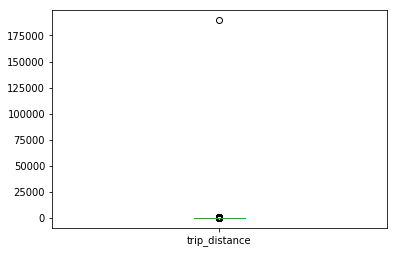

In [22]:
df_clean['trip_distance'].plot.box()

According to RQ5, let's do a first cut at 150

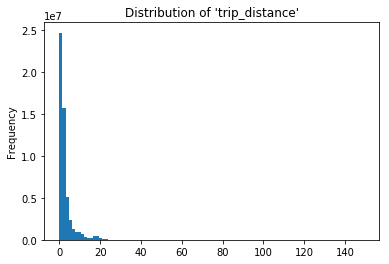

In [24]:
df_clean = df_clean[df_clean.trip_distance < 150]
df_clean['trip_distance'].plot.hist(bins=100, title="Distribution of 'trip_distance'")

Let's investigate Queens 'trip_distance', because it's the borough with the highest mean

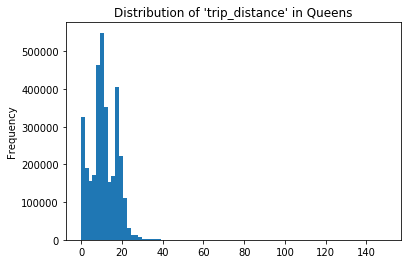

In [25]:
queens = df_clean[df_clean.Borough == "Queens"] # Select all trips from Queens
queens['trip_distance'].plot.hist(bins=80, title="Distribution of 'trip_distance' in Queens")

Analyzing the histogram we decide to cut out all the trips with distance > 35.
This seems a reasonable value to say that trips inside New York hardly cover more than this mileage.
We can also cut out trips with distance less or equal to zero.

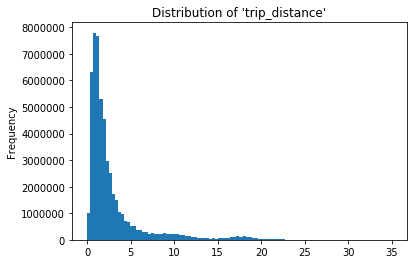

In [26]:
df_clean = df_clean.drop(df_clean[df_clean.trip_distance <= 0].index) # remove rows with trip distance <= 0
df_clean = df_clean.drop(df_clean[df_clean.trip_distance > 35].index) # remove rows with trip distance > 35
df_clean['trip_distance'].plot.hist(bins=100, title="Distribution of 'trip_distance'")

Analysing the NYC Taxi Information document, we found out that there is a minimum fare of 2.5$.
Thus, we can remove trips with 'total_amount' < 2.50 .

In [27]:
df_clean = df_clean.drop(df_clean[df_clean.total_amount < 2.5].index)

Now it's time to investigate the feature 'fare_amount'

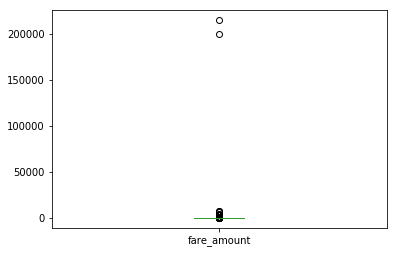

In [28]:
df_clean['fare_amount'].plot.box()

We can clearly see two outliers staind at around 200000. We cut them out together with the values below or equal to zero

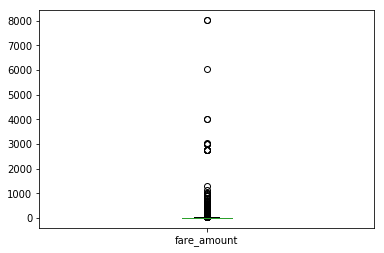

In [29]:
df_clean = df_clean.drop(df_clean[df_clean.fare_amount <= 0].index) # remove rows with fare_amount <= 0
df_clean = df_clean.drop(df_clean[df_clean.fare_amount > 50000].index) # remove rows with fare_amount > 50000
df_clean['fare_amount'].plot.box()

We see other outliers above 2000, we can remove them

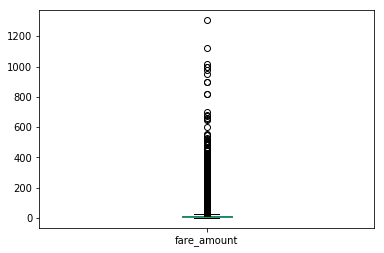

In [30]:
df_clean = df_clean.drop(df_clean[df_clean.fare_amount > 2000].index) # remove rows with fare_amount > 2000
df_clean['fare_amount'].plot.box()

We do another cut at 800

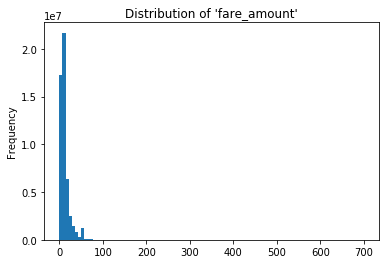

In [33]:
df_clean = df_clean.drop(df_clean[df_clean.fare_amount > 800].index) # remove rows with fare_amount > 800
df_clean['fare_amount'].plot.hist(bins=100, title="Distribution of 'fare_amount'")

The plot is still unbalanced, we do another cut at 150

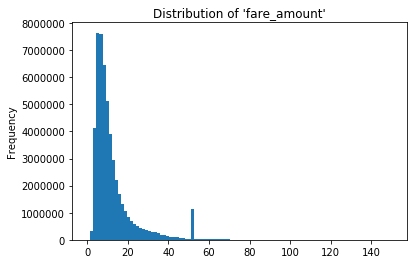

In [34]:
df_clean = df_clean.drop(df_clean[df_clean.fare_amount > 150].index)
df_clean['fare_amount'].plot.hist(bins=100, title="Distribution of 'fare_amount'")

Staten Island is the Borough with the highes fare amount, let's check its distribution

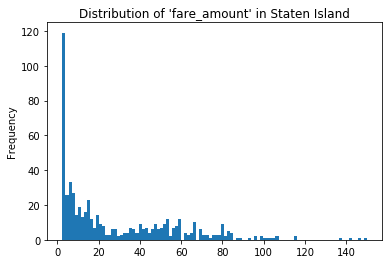

In [35]:
df_clean[df_clean.Borough == 'Staten Island'].fare_amount.plot.hist(bins = 100, title="Distribution of 'fare_amount' in Staten Island")

From this plot we can see that the distribution is almost null after 110.
Thus we can cut there without risking to remove important data

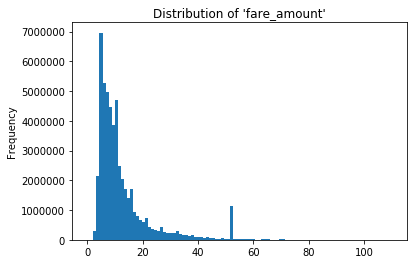

In [37]:
df_clean = df_clean.drop(df_clean[df_clean.fare_amount > 110].index) # remove rows with fare_amount > 110
df_clean['fare_amount'].plot.hist(bins=100, title="Distribution of 'fare_amount'")

Let's check the feature 'trip_duration'

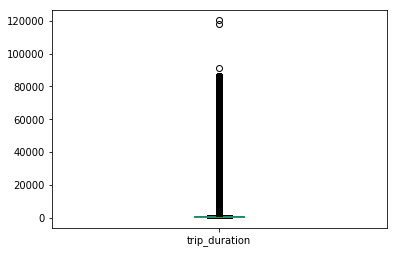

In [38]:
df_clean.trip_duration.plot.box()

There are three outliers, we remove them.
We can remove also trips with 'trip_duration' lower or equal to 60, and > 5000, according to RQ5

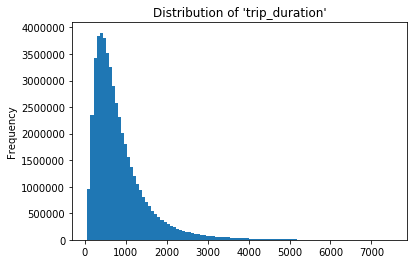

In [39]:
df_clean = df_clean.drop(df_clean[df_clean.trip_duration <= 60].index)
df_clean = df_clean.drop(df_clean[df_clean.trip_duration > 7500].index)
df_clean.trip_duration.plot.hist(bins=100, title="Distribution of 'trip_duration'")

At this point we can consider most of the outliers removed.

In the dataset we have many rows with 'Unknown' borough.
We want to try to re-allocate the trips to the borough with the closest behaviour.

Let's recalculate the means and the stds for the boroughs.

In [40]:
grouped_mean = df_clean.groupby(['Borough']).mean()
grouped_mean = grouped_mean.drop(columns=['PULocationID','DOLocationID']) # Remove not relevant columns
grouped_mean

,trip_distance,fare_amount,total_amount,trip_duration
Borough,,,,
Bronx,4.943338,18.479040,20.994712,1152.633659
Brooklyn,3.606120,14.406378,17.451541,919.891202
Manhattan,2.333934,11.134969,14.051213,768.281660
Queens,11.357324,35.119793,44.572087,1987.550814
Staten Island,9.864222,32.170519,39.972264,1645.974057
Unknown,2.780328,12.461784,15.714565,830.233314


According to the means, trips from 'Unknown' seems to be similar to the trips from 'Manhattan'.

Let's compare the distributions of the features in these two boroughs in order to have some more valid proof.

In [41]:
unknown = df_clean[df_clean.Borough == "Unknown"] # Select all trips from Unknown
manhattan = df_clean[df_clean.Borough == "Manhattan"] # Select all trips from Manhattan

This is the 'trip_distance' distribution comparison using a normalized histogram.

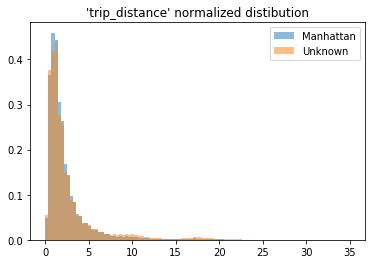

In [45]:
bins = pd.np.linspace(0, 35, 100)

pyplot.hist(manhattan.trip_distance, bins, alpha=0.5, label='Manhattan', density=True)
pyplot.hist(unknown.trip_distance, bins, alpha=0.5, label='Unknown', density=True)
pyplot.legend(loc='upper right')
pyplot.title('\'trip_distance\' normalized distibution')
pyplot.show()

This is the 'trip_duration' distribution comparison using a normalized histogram.

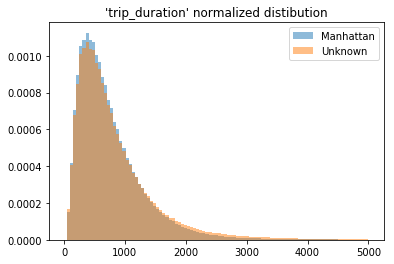

In [46]:
bins = pd.np.linspace(0, 5000, 100)

pyplot.hist(manhattan.trip_duration, bins, alpha=0.5, label='Manhattan', density=True)
pyplot.hist(unknown.trip_duration, bins, alpha=0.5, label='Unknown', density=True)
pyplot.legend(loc='upper right')
pyplot.title('\'trip_duration\' normalized distibution')
pyplot.show()

This is the 'fare_amount' distribution comparison using a normalized histogram.

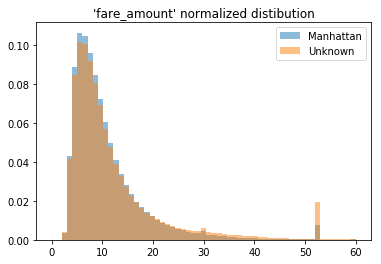

In [47]:
bins = pd.np.linspace(0, 60, 60)

pyplot.hist(manhattan.fare_amount, bins, alpha=0.5, label='Manhattan', density=True)
pyplot.hist(unknown.fare_amount, bins, alpha=0.5, label='Unknown', density=True)
pyplot.legend(loc='upper right')
pyplot.title('\'fare_amount\' normalized distibution')
pyplot.show()

In all the three previouses plots, the features showed pratically the same trend between 'Unknown' and 'Manhattan'.

Thus we can replace the string 'Unknown' with 'Manhattan'.

In [53]:
df_clean.loc[df_clean.Borough == 'Unknown', 'Borough'] = 'Manhattan'

At this point we can consider the dataset (mostly) clean and we can proceed with the analysis asked in CRQ1.

The first main question is: "Does the fare for mile change across NY's borough?"

In order to give an answer, we firstly need to create a new column called 'price_per_mile', filled with the ratio between the trip 'fare_amount' and 'trip_distance'.

In [56]:
df_clean['price_per_mile'] = df_clean.fare_amount / df_clean.trip_distance

Let's check the distribution of the new 'price_per_mile' feature

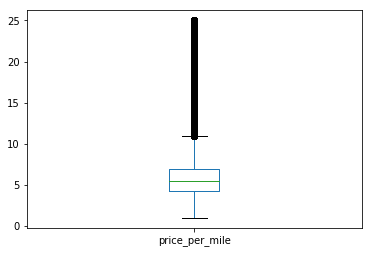

In [61]:
df_clean.price_per_mile.plot.box()

There are some outliers. We'll cut out all the trips with a too high and too low 'price_per_mile'

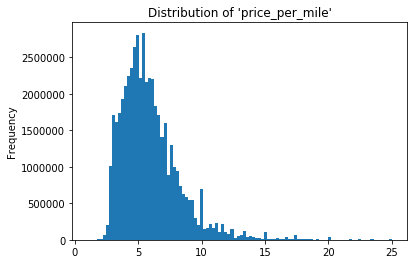

In [60]:
df_clean = df_clean.drop(df_clean[df_clean.price_per_mile > 25].index) # remove rows with 'price_per_mile' > 25
df_clean = df_clean.drop(df_clean[df_clean.price_per_mile < 1].index) # remove rows with 'price_per_mile' < 1

df_clean.price_per_mile.plot.hist(bins=100, title="Distribution of 'price_per_mile'")

Now that outliers are removed, we can recalculate the mean and the std for all the features.

In [63]:
grouped_mean = df_clean.groupby(['Borough']).mean()
grouped_mean = grouped_mean.drop(columns=['PULocationID','DOLocationID'])
grouped_mean

,trip_distance,fare_amount,total_amount,trip_duration,price_per_mile
Borough,,,,,
Bronx,4.971207,18.512439,21.021133,1157.658378,4.893393
Brooklyn,3.614051,14.399958,17.446112,921.736424,5.037699
Manhattan,2.345727,11.155125,14.076923,770.191032,6.123809
Queens,11.382569,35.127804,44.586043,1991.745040,3.478871
Staten Island,10.040268,32.527561,40.317195,1672.856098,4.070754


In [65]:
grouped_std = df_clean.groupby(['Borough']).std()
grouped_std = grouped_std.drop(columns=['PULocationID','DOLocationID'])
grouped_std

,trip_distance,fare_amount,total_amount,trip_duration,price_per_mile
Borough,,,,,
Bronx,5.054078,15.021922,16.936273,967.177151,2.144588
Brooklyn,3.472215,10.468308,12.011114,697.510363,1.974194
Manhattan,2.641690,8.105399,10.149808,566.652197,2.351435
Queens,5.928385,15.571793,19.977542,1079.665442,1.368228
Staten Island,8.822457,25.857163,33.229536,1420.553090,1.906596


And if we plot the distributions of the various boroughs:

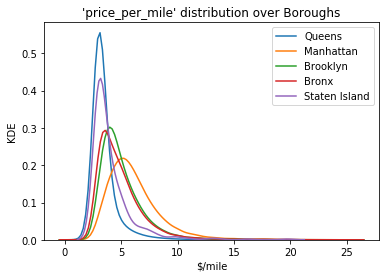

In [78]:
sns.kdeplot(df_clean.price_per_mile[df_clean.Borough == "Queens"],label='Queens', bw=0.5)
sns.kdeplot(df_clean.price_per_mile[df_clean.Borough == "Manhattan"],label='Manhattan', bw=0.5)
sns.kdeplot(df_clean.price_per_mile[df_clean.Borough == "Brooklyn"],label='Brooklyn', bw=0.5)
sns.kdeplot(df_clean.price_per_mile[df_clean.Borough == "Bronx"],label='Bronx', bw=0.5)
sns.kdeplot(df_clean.price_per_mile[df_clean.Borough == "Staten Island"],label='Staten Island', bw=0.5)

plt.xlabel('$/mile')
plt.ylabel('KDE')
plt.title('\'price_per_mile\' distribution over Boroughs')
plt.show()

Let's do a t-test on the 'price_per_mile' series
- H0: means are the same
- H1: means are different

Our p-value treshold is p-value = 0.05

In [80]:
ttest_matrix = pd.DataFrame(index=df_clean.Borough.unique(), columns=df_clean.Borough.unique())

for col1 in df_clean.Borough.unique():
    for col2 in df_clean.Borough.unique():
        ttest_matrix.loc[col1,col2] = stats.ttest_ind(df_clean[df_clean.Borough == col1]['price_per_mile'], df_clean[df_clean.Borough == col2]['price_per_mile']).pvalue
        if col1==col2:
            break
            
ttest_matrix = ttest_matrix.apply(pd.to_numeric)
ttest_matrix

,Manhattan,Bronx,Brooklyn,Queens,Staten Island
Manhattan,1.000000e+00,NaN,NaN,NaN,NaN
Bronx,0.000000e+00,1.000000e+00,NaN,NaN,NaN
Brooklyn,0.000000e+00,1.087040e-51,1.000000e+00,NaN,NaN
Queens,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,NaN
Staten Island,6.087846e-70,1.012173e-14,3.616196e-23,1.986167e-18,1.0


We consider pvalue = 0.05 as a treshold to reject the H0.
Pvalues higher than 0.05 mean that Boroughs have the same mean (we accept the H0)
Pvalues lower than 0.05 mean that Boroughs have different mean (we reject the H0)

H0 is rejected for all the pairs.

Second part of CRQ1 asks us to adjust the price per mile taking in account the traffic.

This is done creating a new feature dividing 'price_per_mile' by 'trip_duration.

We create a new column with 'ppm_adj' with the adjusted price per mile.

In [81]:
df_clean['ppm_adj'] = df_clean.fare_amount/df_clean.trip_duration

df_clean.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID,...,total_amount,Borough,trip_duration,price_per_mile,ppm_adj
2,2018-01-01 00:08:26,2018-01-01 00:14:21,0.8,262,141,...,8.30,Manhattan,355.0,7.500000,0.016901
8,2018-01-01 00:56:38,2018-01-01 01:01:05,1.0,238,24,...,8.50,Manhattan,267.0,5.500000,0.020599
9,2018-01-01 00:17:04,2018-01-01 00:22:24,0.7,170,170,...,6.80,Manhattan,320.0,7.857143,0.017188
10,2018-01-01 00:41:03,2018-01-01 00:46:49,0.6,162,229,...,8.15,Manhattan,346.0,9.166667,0.015896
11,2018-01-01 00:52:54,2018-01-01 01:17:33,3.5,141,113,...,17.80,Manhattan,1479.0,4.714286,0.011156


Let's plot the distribution of the new feature for each borough

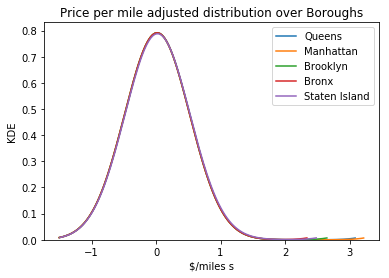

In [82]:
sns.kdeplot(df_clean.ppm_adj[df_clean.Borough == "Queens"],label='Queens', bw=0.5)
sns.kdeplot(df_clean.ppm_adj[df_clean.Borough == "Manhattan"],label='Manhattan', bw=0.5)
sns.kdeplot(df_clean.ppm_adj[df_clean.Borough == "Brooklyn"],label='Brooklyn', bw=0.5)
sns.kdeplot(df_clean.ppm_adj[df_clean.Borough == "Bronx"],label='Bronx', bw=0.5)
sns.kdeplot(df_clean.ppm_adj[df_clean.Borough == "Staten Island"],label='Staten Island', bw=0.5)

# beautifying the labels
plt.xlabel('$/miles s')
plt.ylabel('KDE')
plt.title('Price per mile adjusted distribution over Boroughs')
plt.show()

Now we can update the table with mean and std by borough adding the new columns

In [84]:
grouped_mean = df_clean.groupby(['Borough']).mean()
grouped_mean = grouped_mean.drop(columns=['PULocationID','DOLocationID'])
grouped_mean

,trip_distance,fare_amount,total_amount,trip_duration,price_per_mile,ppm_adj
Borough,,,,,,
Bronx,4.971207,18.512439,21.021133,1157.658378,4.893393,0.017581
Brooklyn,3.614051,14.399958,17.446112,921.736424,5.037699,0.017007
Manhattan,2.345727,11.155125,14.076923,770.191032,6.123809,0.015993
Queens,11.382569,35.127804,44.586043,1991.745040,3.478871,0.019331
Staten Island,10.040268,32.527561,40.317195,1672.856098,4.070754,0.026482


In [85]:
grouped_std = df_clean.groupby(['Borough']).std()
grouped_std = grouped_std.drop(columns=['PULocationID','DOLocationID'])
grouped_std

,trip_distance,fare_amount,total_amount,trip_duration,price_per_mile,ppm_adj
Borough,,,,,,
Bronx,5.054078,15.021922,16.936273,967.177151,2.144588,0.010358
Brooklyn,3.472215,10.468308,12.011114,697.510363,1.974194,0.006978
Manhattan,2.641690,8.105399,10.149808,566.652197,2.351435,0.005356
Queens,5.928385,15.571793,19.977542,1079.665442,1.368228,0.009344
Staten Island,8.822457,25.857163,33.229536,1420.553090,1.906596,0.063955


Finally, we can perform a t-test over the new feature.

- H0: means are the same
- H1: means are different

P-value treshold is still pvalue = 0.05

In [86]:
ttest_matrix_adj = pd.DataFrame(index=df_clean.Borough.unique(), columns=df_clean.Borough.unique())

for col1 in df_clean.Borough.unique():
    for col2 in df_clean.Borough.unique():
        ttest_matrix_adj.loc[col1,col2] = stats.ttest_ind(df_clean[df_clean.Borough == col1]['ppm_adj'], df_clean[df_clean.Borough == col2]['ppm_adj']).pvalue
        if col1==col2:
            break

ttest_matrix_adj = ttest_matrix_adj.apply(pd.to_numeric)
ttest_matrix_adj    

,Manhattan,Bronx,Brooklyn,Queens,Staten Island
Manhattan,1.0,NaN,NaN,NaN,NaN
Bronx,0.0,1.000000e+00,NaN,NaN,NaN
Brooklyn,0.0,9.175426e-61,1.000000e+00,NaN,NaN
Queens,0.0,0.000000e+00,0.000000e+00,1.000000e+00,NaN
Staten Island,0.0,3.743809e-51,1.236487e-157,8.242222e-54,1.0


We consider pvalue = 0.05 as a treshold to reject the H0.
Pvalues higher than 0.05 mean that Boroughs have the same mean (we accept the H0)
Pvalues lower than 0.05 mean that Boroughs have different mean (we reject the H0)

It happened that again all the boroughs have different means, so there are boroughs more expensive than others